In [67]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pygame
from torchvision.transforms.functional import rotate

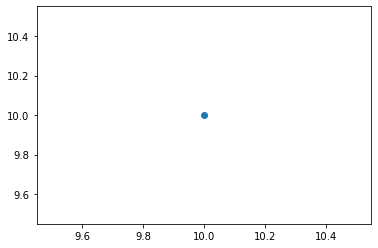

In [68]:
pos_x = t.tensor([[10]]).cuda()
pos_y = t.tensor([[10]]).cuda()
plt.scatter(pos_x.cpu().numpy(), pos_y.cpu().numpy())

In [69]:
# DIM = 3
# CARRIERS = 9
NUM_AGENTS = 8
NUM_STATES = 3
NUM_PERCEPTIONS = 3
NUM_ACTIONS = 512
NUM_THINGS = 3
# Model testing
MULT = 2
RES = 512

def rotate(x, angle): 
    ca = t.cos(angle)
    sa = t.sin(angle)
    
    return t.cat([ca*x[:,:,:,0:1]+sa*x[:,:,:,1:2], -sa*x[:,:,:,0:1]+ca*x[:,:,:,1:2]], 3)

def sigmoid(x):
    return 1/(1+np.exp(-0.25 * x))

# dim 3 carries the x,y variation
def mirror(p):
    p = RES-1-p
    w1 = t.le(p,0).long()
    p = (1-w1)*p + w1*(-p)

    p = RES-1-p
    w1 = t.le(p,0).long()
    p = (1-w1)*p + w1*(-p)
    
    return p

# class RadConv(nn.Module):
#     def __init__(self, NI, radius):
#         super().__init__()
#         self.conv = nn.Conv2d(NI, NI, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        
#         avg_weight = t.zeros_like(self.conv.weight.data)
        
#         for theta in np.arange(0,2*np.pi,np.pi/256.0):
#             avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/np.pi)/128.0
        
#         avg_weight /= avg_weight.sum(3).sum(2).unsqueeze(2).unsqueeze(3)
        
#         self.conv.weight.data = avg_weight
#         for i in range(NI):
#             for j in range(i):
#                 self.conv.weight.data[i,j] = 0
#                 self.conv.weight.data[j,i] = 0
    
#     def forward(self, x):
#         return self.conv(x)

class RadConv(nn.Module):
    def __init__(self, NI, NO, radius):
        super().__init__()
        self.conv = nn.Conv2d(NI, NO, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        
        avg_weight = t.zeros_like(self.conv.weight.data)
        
        for theta in np.arange(0,2*t.pi,t.pi/256.0):
            avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/t.pi)/t.sqrt(512.0)
        
        #avg_weight /= avg_weight.sum(3).sum(2).unsqueeze(2).unsqueeze(3)
        
        self.conv.weight.data = avg_weight
    
    def forward(self, x):
        return self.conv(x)

In [70]:
t.tensor(np.arange(0,2*np.pi,np.pi/256.0)).cuda().shape

torch.Size([512])

In [71]:
positions = t.rand(NUM_AGENTS, 2).cuda(); print(positions.shape)
directions = t.tensor([theta for theta in np.arange(0,2*np.pi,np.pi/256.0)]).cuda().view(NUM_ACTIONS, 1); print(directions.shape)
num_directions = directions.shape[0]; print(num_directions)
speeds = t.tensor([speed for speed in t.rand(num_directions)]).cuda().view(NUM_ACTIONS, 1); print(speeds.shape)
actions = t.cat([speeds, directions], 1); print(actions.shape)

torch.Size([8, 2])
torch.Size([512, 1])
512
torch.Size([512, 1])
torch.Size([512, 2])


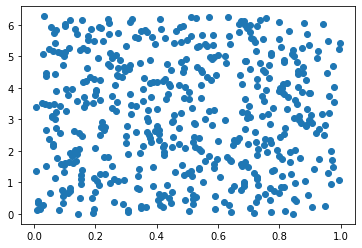

In [72]:
plt.scatter(actions.cpu().numpy()[:, 0], actions.cpu().numpy()[:, 1])

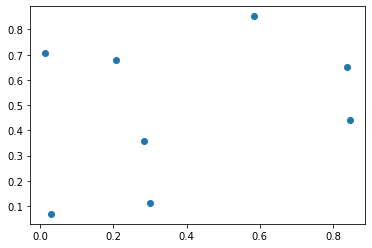

In [73]:
plt.scatter(positions.cpu().numpy()[:, 0], positions.cpu().numpy()[:, 1])

In [77]:
radius = 5

class Agent(nn.Module):
    
    def __init__(self, position = t.rand(512, 512), action = t.randint(low=0, high = 1, size = (1, NUM_ACTIONS)), state = t.rand(1, NUM_STATES), perception = t.rand(1, NUM_PERCEPTIONS), things = t.rand(1, NUM_THINGS)):
        super().__init__()
        
        self.position = position; print(self.position.shape)

        self.action = action; print(self.action.shape)
        self.state = state; print(self.state.shape)
        self.perception = perception; print(self.perception.shape)

        # self.action = action.view(-1, 1); print(self.action.shape)
        # self.state = state.view(-1, 1); print(self.state.shape)
        # self.perception = perception.view(-1, 1); print(self.perception.shape)
        self.config = t.cat([self.perception.view(-1, NUM_PERCEPTIONS), self.state.view(-1, NUM_STATES), self.action.view(-1, NUM_ACTIONS)], dim = 1); print(self.config.shape)
        
        self.percept = RadConv(NI = NUM_PERCEPTIONS+NUM_STATES, NO = NUM_PERCEPTIONS+NUM_STATES, radius = radius) #things in the environment; other agents states, their perception etc; NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        # self.conv = nn.Conv2d(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_PERCEPTIONS*NUM_STATES, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        self.fc1 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_PERCEPTIONS+NUM_STATES)
        self.fc2 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_PERCEPTIONS)
        self.fc3 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_STATES)
        self.fc4 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_ACTIONS)

    def forward(self, x):
        print(self.state)
        perception, states = F.relu(self.percept(x)) #should be NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS -> NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        # perception, states = F.relu(self.conv(x))
        print(perception)
        print(states)
        self.perception = F.relu(self.fc1(t.tensor(t.cat([perception, states], dim=0)).view(-1, NUM_PERCEPTIONS+NUM_STATES))); print(self.perception)
        self.perception = F.softmax(self.fc2(self.perception))
        self.state = F.softmax(self.fc3(self.perception).view(-1, NUM_STATES))
        self.action = F.softmax(self.fc4(self.perception).view(-1, NUM_ACTIONS))
        self.config = t.tensor(t.cat([self.perception, self.state, self.action], dim=1))
        return self.config

In [78]:
class Predator(Agent):
    def __init__(self):
        super(Agent, self).__init__()

class Prey(Agent):
    def __init__(self):
        super(Agent, self).__init__()

In [79]:
Agent().config


torch.Size([512, 512])
torch.Size([1, 512])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 518])


TypeError: cos(): argument 'input' (position 1) must be Tensor, not numpy.float64

In [15]:
preys_[0].state

NameError: name 'preys_' is not defined

In [20]:
agents = dict(preys=t.tensor([prey.state for prey in preys_]).view(-1, 1), predators=t.tensor([predator.state for predator in predators]).view(-1, 1))

AttributeError: 'Prey' object has no attribute 'state'

In [130]:
class Environment(nn.Module):
    def __init__(self, spatial_contents, env_state, preys, predators):
        super(Environment, self).__init__()
        self.spatial_contents = spatial_contents
        self.config = env_state
        self.predators = predators
        self.preys = preys
        self.fc1 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_ACTIONS) # env_variables + (positions + action + perceptions) of all agents -> some number
        self.fc2 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_PERCEPTIONS)
        self.fc3 = nn.Linear((NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_STATES)
        # self.fc3 = nn.Linear(128, contents)
    
    def _state(self):
        self.config = t.cat(t.tensor([self.predators, self.preys]))
        return self.config
    
    def __get__(self, x=None):
        x = self._state()
        return self.forward(x)

    def forward(self, x):
        
        # x = t.cat(
        #     [t.tensor(list(self.env_state.values)).view(-1, 1), 
        #     t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in self.predators])).view(-1, 1), 
        #     t.flatten(t.tensor([[prey.state, prey.perceptions, prey.actions] for prey in self.preys]))]).cuda()
        
        x = self.config.view(-1, 1)         
        actions = F.softmax(F.relu(self.fc1(x)).view(NUM_AGENTS, NUM_ACTIONS))
        perceptions = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_PERCEPTIONS))
        states = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_STATES))
        return t.cat([actions, perceptions, states]).cuda()

In [142]:
env = Environment(t.tensor([]), t.cat(t.tensor([predators, preys]) ), preys, predators)

Conf = env(env.config)

RuntimeError: Could not infer dtype of Predator

In [118]:
[p.forward() for p in env.predators]

TypeError: Agent.forward() missing 1 required positional argument: 'x'

In [111]:
class Environment(nn.Module):
    def __init__(self, spatial_contents, env_state, agents):
        super(Environment, self).__init__()
        self.spatial_contents = spatial_contents
        self.state = env_state
        self.predators = agents["predators"]
        self.preys = agents["preys"]
        self.fc1 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_ACTIONS) # env_variables + (positions + action + perceptions) of all agents -> some number
        self.fc2 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_PERCEPTIONS)
        self.fc3 = nn.Linear(len(env_state.values)*(NUM_AGENTS*NUM_ACTIONS*NUM_PERCEPTIONS*NUM_STATES), NUM_AGENTS*NUM_STATES)
        # self.fc3 = nn.Linear(128, contents)

    def forward(self, x):
        
        x = t.cat(
            [t.tensor(list(self.env_state.values)).view(-1, 1), 
            t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in self.predators])).view(-1, 1), 
            t.flatten(t.tensor([[prey.state, prey.perceptions, prey.actions] for prey in self.preys]))]).cuda()
            
        actions = F.softmax(F.relu(self.fc1(x)).view(NUM_AGENTS, NUM_ACTIONS))
        perceptions = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_ACTIONS))
        states = F.softmax(F.relu(self.fc2(x)).view(NUM_AGENTS, NUM_ACTIONS))
        return t.cat([actions, perceptions, states])

In [46]:
t.flatten(t.tensor([[predator.state, predator.perceptions, predator.actions] for predator in predators])).view(-1, 1)

NameError: name 'predators' is not defined

In [ ]:
pygame.init()
screen = pygame.display.set_mode((MULT*RES,MULT*RES), 0, 24)
